In [1]:
import json
import argparse
import numpy as np
import pandas as pd
import seaborn as sns
from datasets import load_dataset, Dataset, load_from_disk
import matplotlib.pyplot as plt 
from transformers import AutoTokenizer

/home/yilong/miniconda3/envs/vllm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_parquet('../data/tom/exploretom/train.parquet')
dft = pd.read_parquet('../data/tom/exploretom/test.parquet')

In [44]:
len(df)

10647

In [3]:
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-0.5B-Instruct", trust_remote_code=True)

In [4]:
len(dft)

2662

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10647 entries, 0 to 10646
Data columns (total 23 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   story_structure                          10647 non-null  object 
 1   infilled_story                           10647 non-null  object 
 2   question                                 10647 non-null  object 
 3   expected_answer                          10647 non-null  object 
 4   qprop=params                             10647 non-null  object 
 5   qprop=nth_order                          10647 non-null  int64  
 6   qprop=non_unique_mental_state            10647 non-null  bool   
 7   sprop=is_false_belief_story_1st          10647 non-null  bool   
 8   sprop=is_false_belief_story_1st_and_2nd  10647 non-null  bool   
 9   sprop=story_accuracy_1st_raw             10647 non-null  float64
 10  sprop=story_accuracy_1st_infilled        10647

In [23]:
df.groupby(['param=story_type']).prompt.count()

param=story_type
all                               707
all+asymmetric                    701
allbutfantom                      132
allbutfantom+asymmetric           143
fantom-private                   1109
fantom-private+asymmetric         804
fantom-public                    1361
fantom-public+asymmetric         1043
tomi                              825
tomi+asymmetric                   497
tomi+info-exchange                408
tomi+info-exchange+asymmetric     299
tomi+object-state                 701
tomi+object-state+asymmetric      469
tomi+room-changes                 122
tomi+room-changes+asymmetric      122
tomi-object-state                 817
tomi-object-state+asymmetric      387
Name: prompt, dtype: int64

In [46]:
df.groupby(['qprop=non_unique_mental_state','qprop=nth_order']).story_structure.count()

qprop=non_unique_mental_state  qprop=nth_order
False                           1                 1302
                                2                 4111
True                           -1                  669
                                1                 1322
                                2                 3243
Name: story_structure, dtype: int64

# Clean data

## Check Answer

In [25]:
ans_freq = (df.groupby('expected_answer').question.count()/len(df)).reset_index()
ans_freq.sort_values(by='question', inplace=True, ascending=False)
ans_freq.head(15)

,expected_answer,question
138,yes,0.220626
49,does not know about it,0.195360
67,knows about it,0.157885
97,no,0.039917
105,plastic storage bin,0.023763
100,operations room,0.020569
26,cardboard box,0.020381
94,metal toolbox,0.014746
133,wooden chest,0.014182
41,consulate meeting room,0.011177


In [26]:
len(ans_freq)

139

In [16]:
out_list = ['yes', 'does not know about it', 'knows about it', 'no']

In [22]:
df.loc[df.expected_answer.isin(out_list)].groupby(['qprop=non_unique_mental_state','qprop=nth_order']).prompt.count()

qprop=non_unique_mental_state  qprop=nth_order
False                          1                   913
                               2                  1315
True                           1                  1216
                               2                  3091
Name: prompt, dtype: int64

<Axes: xlabel='sprop=story_accuracy_1st_infilled', ylabel='Count'>

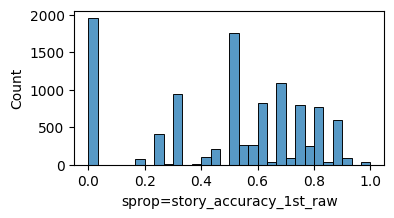

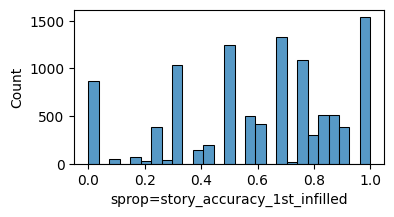

In [27]:
_, ax = plt.subplots(1, 1, figsize=(4, 2))
sns.histplot(x=df['sprop=story_accuracy_1st_raw'], ax=ax)

_, ax = plt.subplots(1, 1, figsize=(4, 2))
sns.histplot(x=df['sprop=story_accuracy_1st_infilled'], ax=ax)

Remove answer

In [ ]:
df_ = df.loc[~df.expected_answer.isin(out_list)]
df_train = pd.concat([df_, df_], ignore_index=True)
df_train['story'] = np.concatenate([df_.infilled_story.values, df_.story_structure.values])
df_train['story_type']=['infilled_story']*len(df_)+ ['story_structure']*len(df_)
df_train = df_train.sample(frac=1, random_state=42)
df_train = df_train.loc[df_train['sprop=story_accuracy_1st_raw']<0.8]
df_train.index = range(len(df_train))
df_train = df_train.drop(columns=['infilled_story', 'story_structure'])
df_train = df_train.rename(columns={'expected_answer':'answer'})

In [49]:
df_test = pd.concat([dft, dft], ignore_index=True)
df_test['story'] = np.concatenate([dft.infilled_story.values, dft.story_structure.values])
df_test['story_type']=['infilled_story']*len(dft)+ ['story_structure']*len(dft)
df_test = df_test.drop(columns=['infilled_story', 'story_structure'])
df_test.index = range(len(df_test))
df_test = df_test.rename(columns={'expected_answer':'answer'})
dft = dft.rename(columns={'expected_answer':'answer'})

In [32]:
len(df_train)

7958

In [31]:
0.5*len(df_train)/len(df)

0.37372029679721985

In [33]:
dfi = df_train.groupby(['qprop=params','param=num_people']).data_source.count().reset_index()
dfi.head(2)

,qprop=params,param=num_people,data_source
0,"(None, 'bag of gourmet coffee beans', 'ground_...",2,2
1,"(None, 'bag of gourmet coffee beans', 'memory-...",2,2


In [35]:
dfi.data_source.max()

18

In [43]:
df_train.groupby(['qprop=non_unique_mental_state','qprop=nth_order']).story.count()

qprop=non_unique_mental_state  qprop=nth_order
False                           1                  722
                                2                 5460
True                           -1                 1294
                                1                  198
                                2                  284
Name: story, dtype: int64

In [47]:
SYSTEM_PROMPT = """You are a helpful assistant. The assistant first thinks about the question in the mind and then provides the user with the final answer. The reasoning process and answer are enclosed within <think> </think> and <answer> </answer> tags, respectively, i.e., <think> step by step reasoning here </think><answer> answer here </answer>."""

XML_COT_FORMAT = """Story: {}\n Question:{}"""

In [50]:
def generate_prompt(x, i):
    data = { # type: ignore
            'prompt': [
                {'role': 'system', 'content': SYSTEM_PROMPT},
                {'role': 'user', 'content': XML_COT_FORMAT.format(x['story'], x['question'])}
            ],
            'answer': x['answer']
        }
    return data

In [51]:
data = Dataset.from_pandas(df_train)
test_data = Dataset.from_pandas(df_test)

In [52]:
data = data.map(generate_prompt, with_indices=True)
test_data = test_data.map(generate_prompt, with_indices=True)

Map:   0%|          | 0/7958 [00:00<?, ? examples/s]

Map: 100%|██████████| 5324/5324 [00:00<00:00, 11400.83 examples/s]


In [53]:
len(data['prompt'])

7958

<Axes: ylabel='Count'>

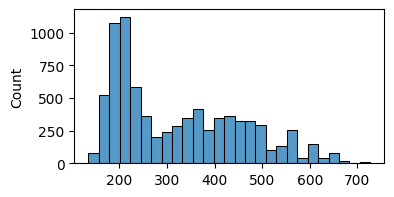

In [54]:
token_lengths = []
for prompt_list in data['prompt']:
    # Each prompt is a list of dictionaries, we want the 'content' of the first dict
    # Tokenize the content
    tokens = tokenizer.apply_chat_template(prompt_list)
    token_lengths.append(len(tokens))

token_lengths = np.array(token_lengths)
_, ax = plt.subplots(1, 1, figsize=(4, 2))
sns.histplot(token_lengths)

In [55]:
len(token_lengths)

7958

In [56]:
np.median(token_lengths)

293.0

In [57]:
df_train_ = df_train.iloc[np.arange(len(token_lengths))[token_lengths<384]]
df_train_.index = range(len(df_train_))

In [58]:
df_train_full_tom = df_train_.loc[df_train_['qprop=non_unique_mental_state']==True].copy()
df_train_full_tom.index = range(len(df_train_full_tom))

df_train_no_tom = df_train_.loc[df_train_['qprop=non_unique_mental_state']==False].copy()
df_train_no_tom.index = range(len(df_train_no_tom))

In [59]:
print(df_train_['sprop=story_accuracy_1st_infilled'].mean(), df_train['sprop=story_accuracy_1st_infilled'].mean())

0.43974757164323275 0.44829945507565505


In [60]:
len(df_train_)

5324

In [61]:
data_train = Dataset.from_pandas(df_train_)
data_train = data_train.map(generate_prompt, with_indices=True)

data_train_full_tom = Dataset.from_pandas(df_train_full_tom)
data_train_full_tom = data_train_full_tom.map(generate_prompt, with_indices=True)

data_train_no_tom = Dataset.from_pandas(df_train_no_tom)
data_train_no_tom = data_train_no_tom.map(generate_prompt, with_indices=True)

Map: 100%|██████████| 4206/4206 [00:00<00:00, 11023.39 examples/s]


In [62]:
data_train

Dataset({
    features: ['question', 'answer', 'qprop=params', 'qprop=nth_order', 'qprop=non_unique_mental_state', 'sprop=is_false_belief_story_1st', 'sprop=is_false_belief_story_1st_and_2nd', 'sprop=story_accuracy_1st_raw', 'sprop=story_accuracy_1st_infilled', 'sprop=global_idx', 'param=story_type', 'param=num_stories_total', 'param=max_sentences', 'param=num_people', 'param=num_moves', 'param=num_rooms', 'data_source', 'prompt', 'ability', 'reward_model', 'extra_info', 'story', 'story_type'],
    num_rows: 5324
})

In [64]:
test_data.to_parquet('cleaned_data/cleaned_test.parquet')
data_train.to_parquet('cleaned_data/cleaned_train_384token.parquet')

Creating parquet from Arrow format: 100%|██████████| 6/6 [00:00<00:00, 339.39ba/s]


15879144

In [65]:
data_train_full_tom.to_parquet('cleaned_data/cleaned_train_ft_384.parquet')
data_train_no_tom.to_parquet('cleaned_data/cleaned_train_nt_384.parquet')

Creating parquet from Arrow format: 100%|██████████| 5/5 [00:00<00:00, 350.61ba/s]


12427189

## Create Balanced Data

In [66]:
dfnt = pd.DataFrame(data_train_no_tom)
dfft = pd.DataFrame(data_train_full_tom)

In [68]:
print(len(dfft))

1118


In [72]:
FT = 1118
NT = 1200-FT

In [74]:
dfn = dfnt.sample(n = NT, replace=False, ignore_index=True, random_state=42)
df = pd.concat([dfn.loc[:, ['ability', 'story', 'answer', 'prompt']], dfft.loc[:, ['ability', 'story', 'answer', 'prompt']] ])
df = df.sample(frac=1, replace=False, ignore_index=True)
df.head(2)

,ability,story,answer,prompt
0,theory_of_mind,Kaitlyn entered the operations room. Kaitlyn m...,plastic storage bin,[{'content': 'You are a helpful assistant. The...
1,theory_of_mind,"The student lounge was quiet, its worn couches...",canvas tote bag,[{'content': 'You are a helpful assistant. The...


In [76]:
data =Dataset.from_pandas(df)
data.to_parquet('cleaned_data/ToM_train_1.2k.parquet')

Creating parquet from Arrow format: 100%|██████████| 2/2 [00:00<00:00, 709.70ba/s]


2398241